<a href="https://colab.research.google.com/github/matteoturnu/NetSecProject/blob/main/NetSec_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Studying features correlation and distribution

## Prepararing the dataset

Importing the needed libraries

In [3]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

Loading and setting the dataset

In [4]:
url = 'https://raw.githubusercontent.com/matteoturnu/NetSecProject/refs/heads/main/BenignAndMaliciousDataset.csv'
traffic_df = pd.read_csv(url)
print(traffic_df.shape)

# We only select numeric and boolean features
numeric_dataset = traffic_df.select_dtypes(include=['number','boolean'])

# We remove Domain because it is an incremental ID
new_numeric_dataset = numeric_dataset.drop(columns='Domain')
# we remove Ip and ASN because they are based on strings "de facto" so it doesn't make sense to study correlation
excluded_features = ['Ip', 'ASN']
new_numeric_dataset = new_numeric_dataset.drop(columns=excluded_features)

(90000, 34)


## Bening and malicious traffic distribution based on remaining features

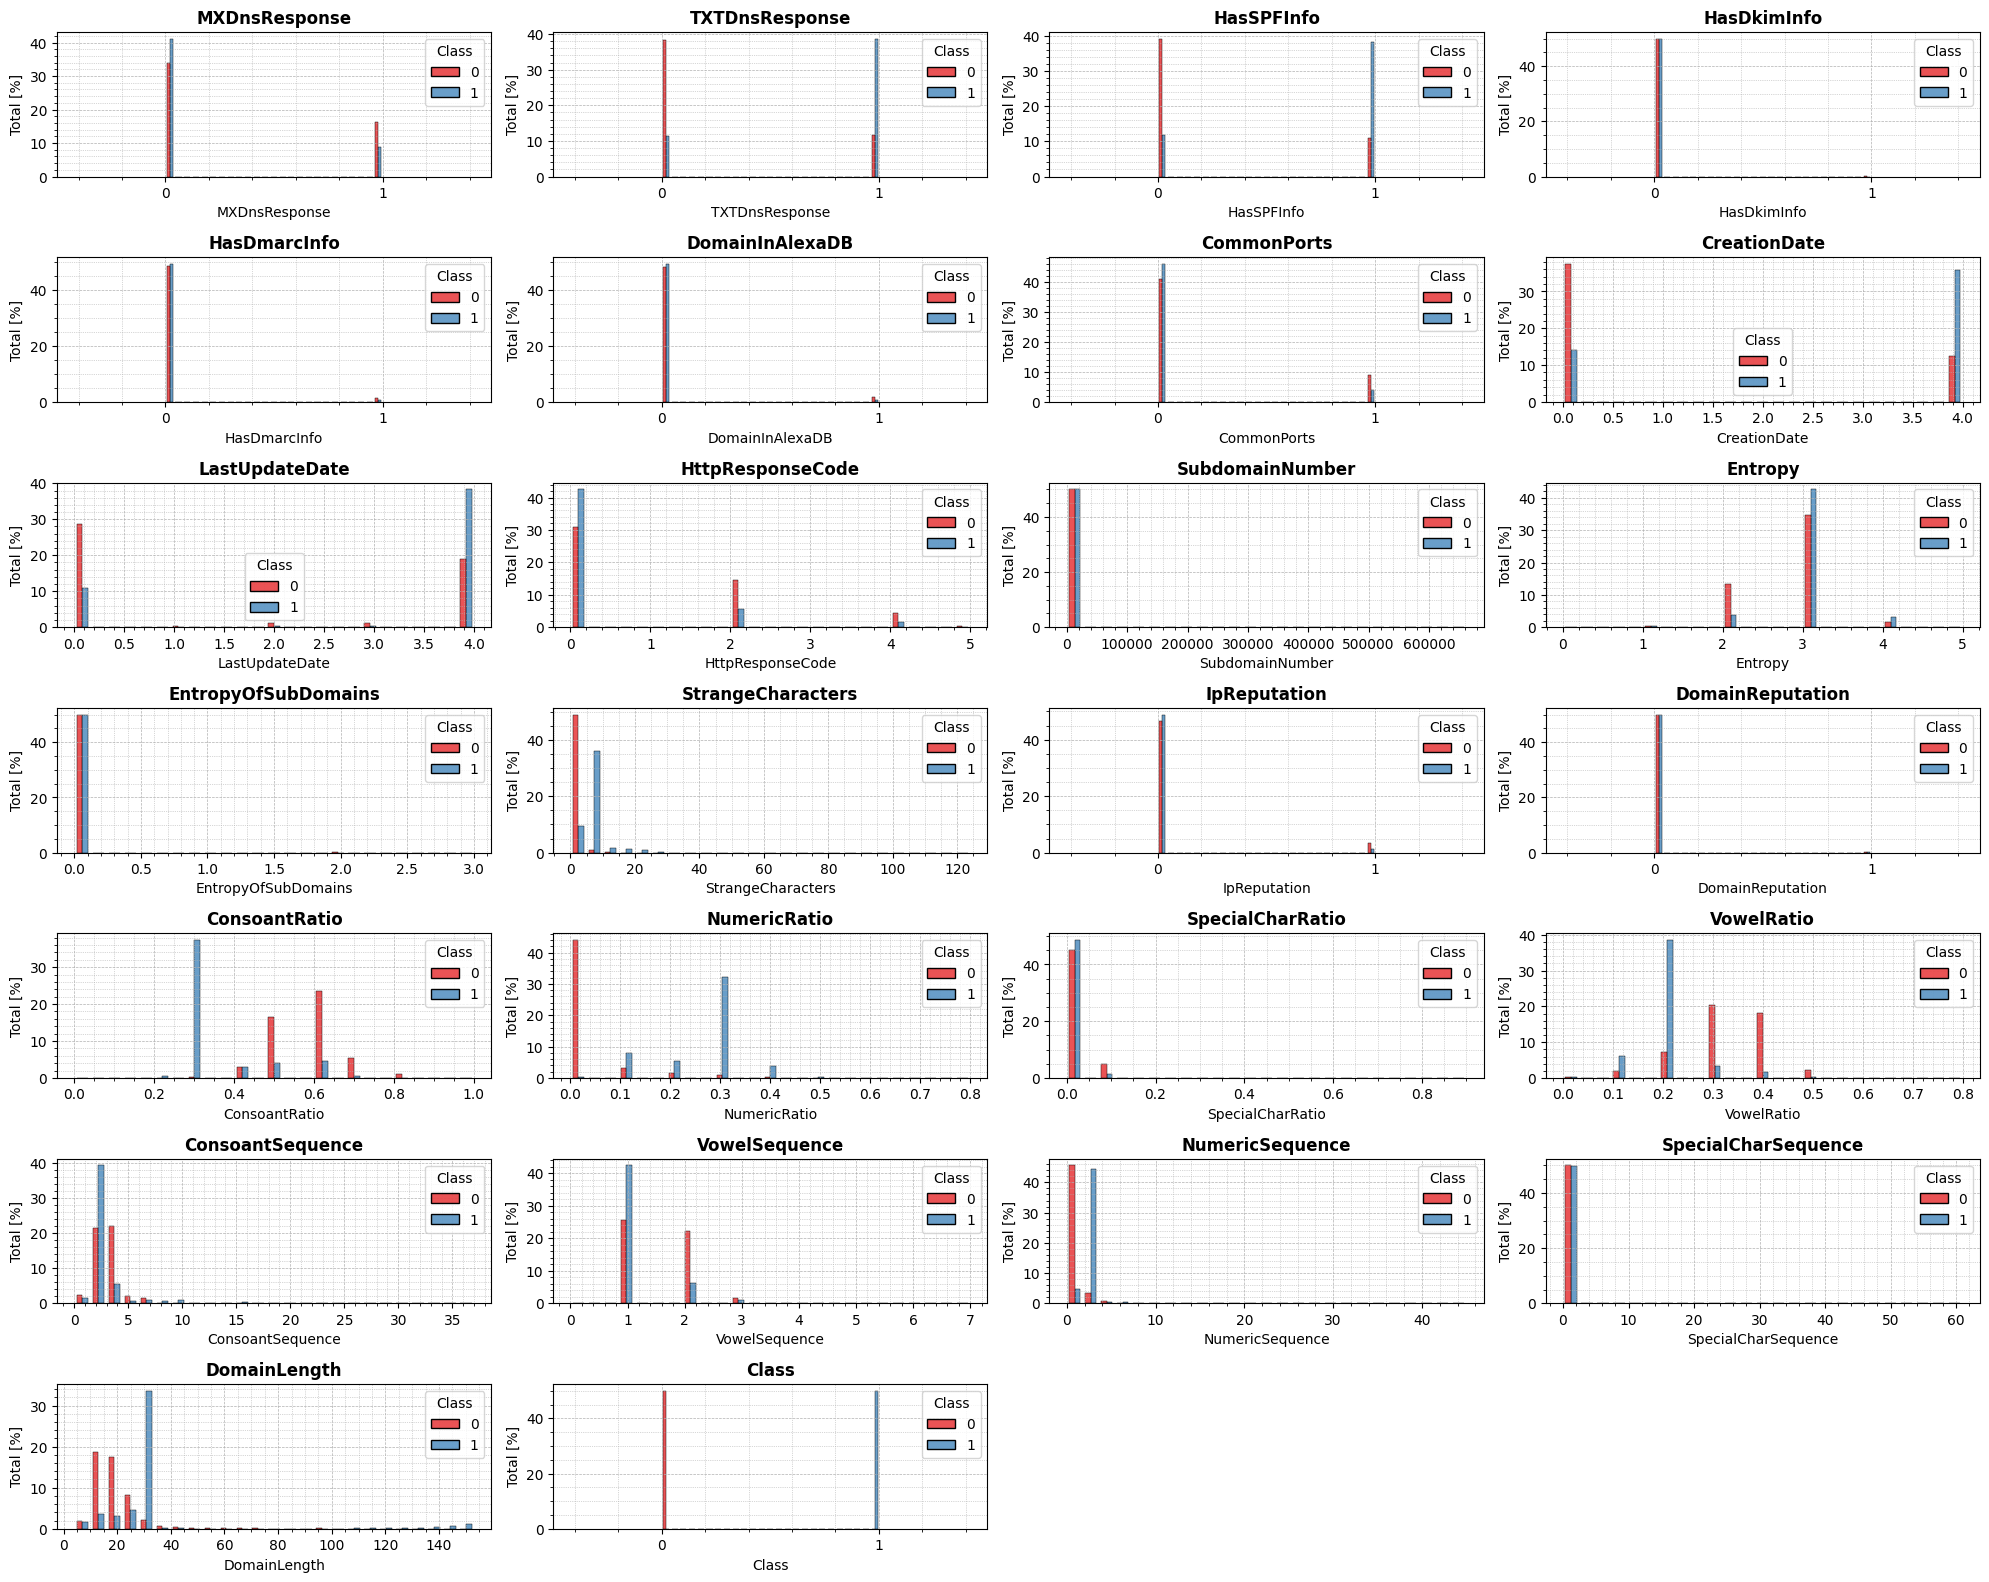

In [5]:
plt.figure(figsize=(20, 20))

for i, feature in enumerate(new_numeric_dataset, 1):
    plt.subplot(9, 4, i)
    plot = sns.histplot(data=traffic_df, x=feature, hue='Class', multiple='dodge', palette='Set1', bins=25, stat='percent', shrink = 0.7)

    if traffic_df[feature].nunique() == 2:  # Check if the current feature is boolean
        plt.xticks([0, 1])
        plt.xlim(-0.5, 1.5)

    plt.title(f'{feature}', fontweight='bold')
    plt.ylabel('Total [%]')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5)


plt.tight_layout()
plt.show()

Graphs show some features are equally distributed among malicious and bening samples

In [6]:
# remove overlapping features
new_numeric_dataset = new_numeric_dataset.drop(columns=['HasDkimInfo', 'HasDmarcInfo', 'DomainInAlexaDB', 'SubdomainNumber', 'CommonPorts', 'EntropyOfSubDomains', 'IpReputation', 'DomainReputation', 'SpecialCharRatio', 'SpecialCharSequence'])

## Distribution of excluded features

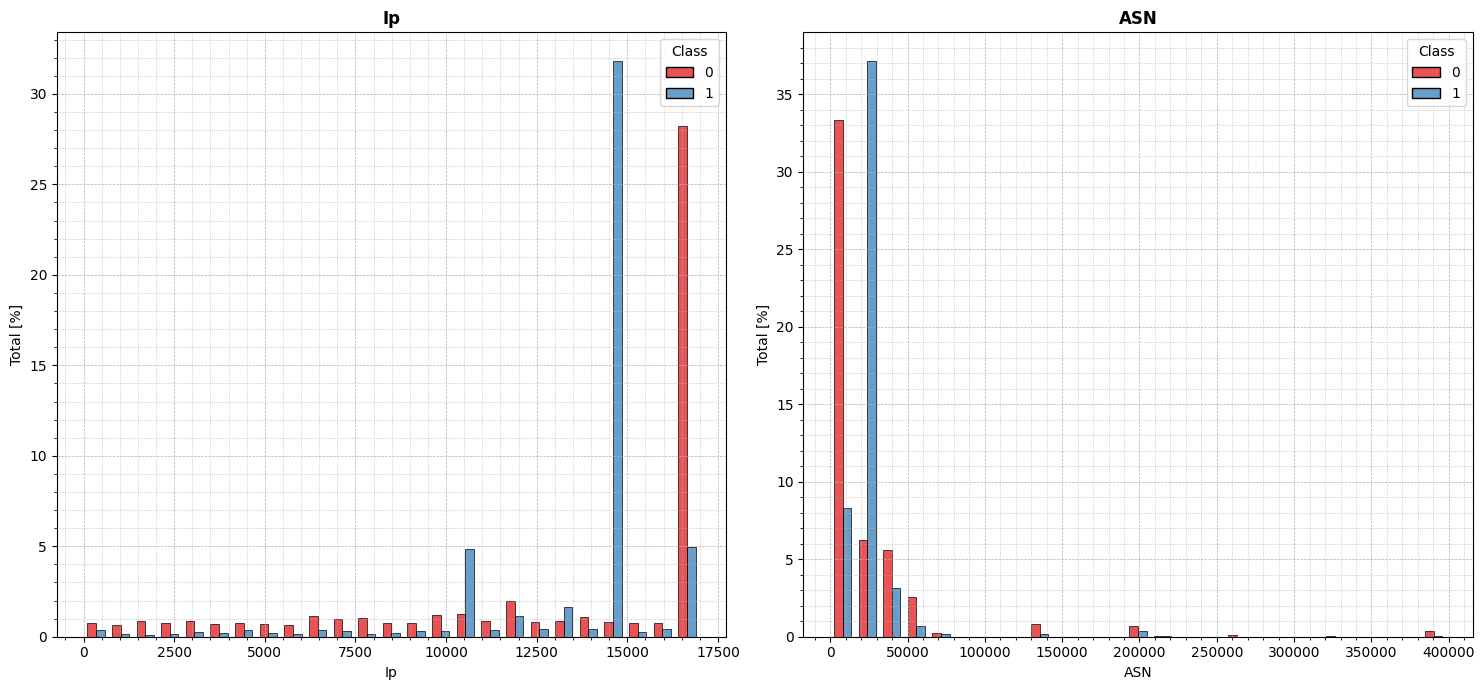

In [7]:
plt.figure(figsize=(15, 7))

for i, feature in enumerate(excluded_features, 1):
    plt.subplot(1, 2, i)
    plot = sns.histplot(data=traffic_df, x=feature, hue='Class', multiple='dodge', palette='Set1', bins=25, stat='percent', shrink = 0.7)

    plt.title(f'{feature}', fontweight='bold')
    plt.ylabel('Total [%]')

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

## Studying feature-target correlation

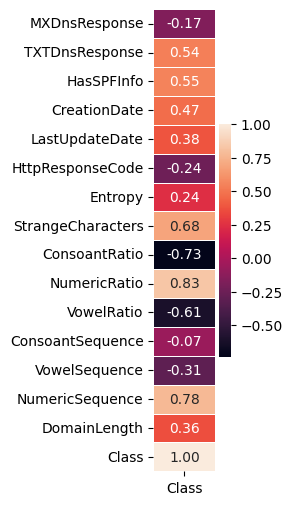

In [8]:
corr_matrix = new_numeric_dataset.corr()
class_corr = corr_matrix[['Class']]
plt.figure(figsize=(1, 6))
sns.heatmap(class_corr, annot=True, linewidths=0.5, fmt='.2f')
plt.show()

## Studying pairwise feature correlation

<Axes: >

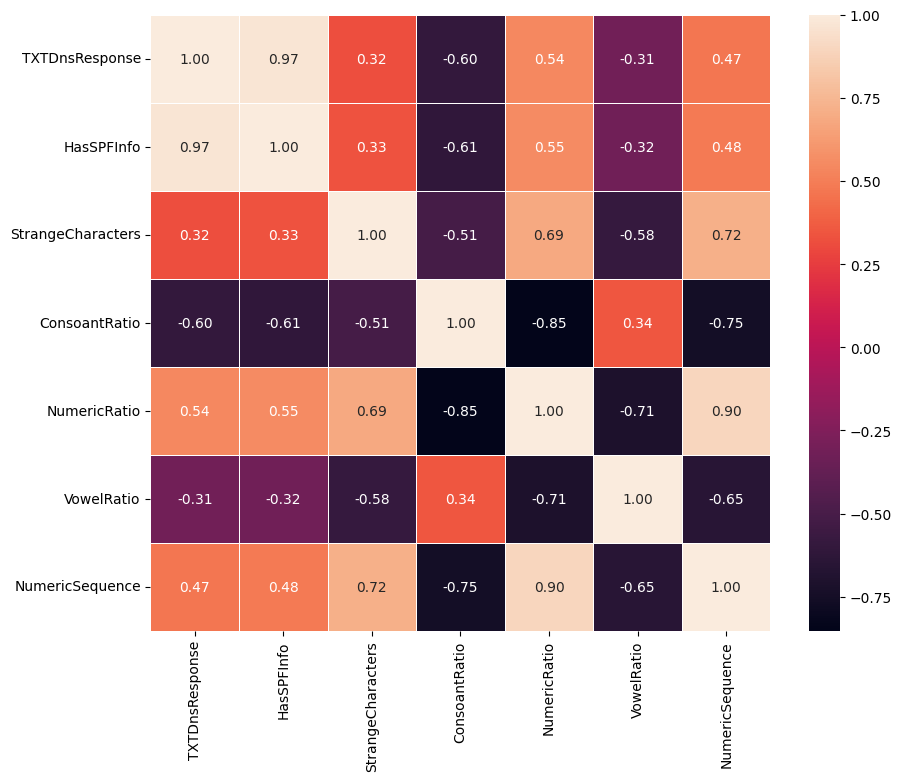

In [9]:
new_numeric_dataset = new_numeric_dataset.drop(columns=['MXDnsResponse', 'CreationDate', 'LastUpdateDate', 'HttpResponseCode', 'Entropy', 'ConsoantSequence', 'VowelSequence', 'DomainLength', 'Class'])

corr_matrix = new_numeric_dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, linewidth=0.5, fmt='.2f')

In [10]:
final_features = ['TXTDnsResponse', 'StrangeCharacters', 'VowelRatio', 'NumericSequence']

# Choosing the ML classifier

Test to evaluate how much the samples distribution is a Gaussian one


In [11]:
# We remove boolean features from the study
study_features=['TXTDnsResponse', 'StrangeCharacters', 'VowelRatio', 'NumericSequence', 'Class']
dataset_study=traffic_df[study_features]

# We divide dataset in benign and malicious
dataset_ben = dataset_study[dataset_study['Class']==1]
dataset_mal = dataset_study[dataset_study['Class']==0]


# Shapiro-Wilk test on benign dataset
print('Benign dataset:')
stat, p_value = stats.shapiro(dataset_ben)
print('Statistic:', stat)
print('p-value:', p_value)
if p_value > 0.05:
    print('Distribution is likely to be normal (not rejecting H0)')
else:
    print('Distribution is not normal (rejecting H0)')

# Shapiro-Wilk test on malicious dataset
print('\nMalicious dataset:')
stat, p_value = stats.shapiro(dataset_mal)
print('Statistic:', stat)
print('p-value:', p_value)
if p_value > 0.05:
    print('Distribution is likely to be normal (not rejecting H0)')
else:
    print('Distribution is not normal (rejecting H0)')

Benign dataset:


/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 225000.
  res = hypotest_fun_out(*samples, **kwds)


Statistic: 0.6557978084271938
p-value: 1.0974990318937638e-168
Distribution is not normal (rejecting H0)

Malicious dataset:
Statistic: 0.27542616677874854
p-value: 5.985520266058562e-195
Distribution is not normal (rejecting H0)


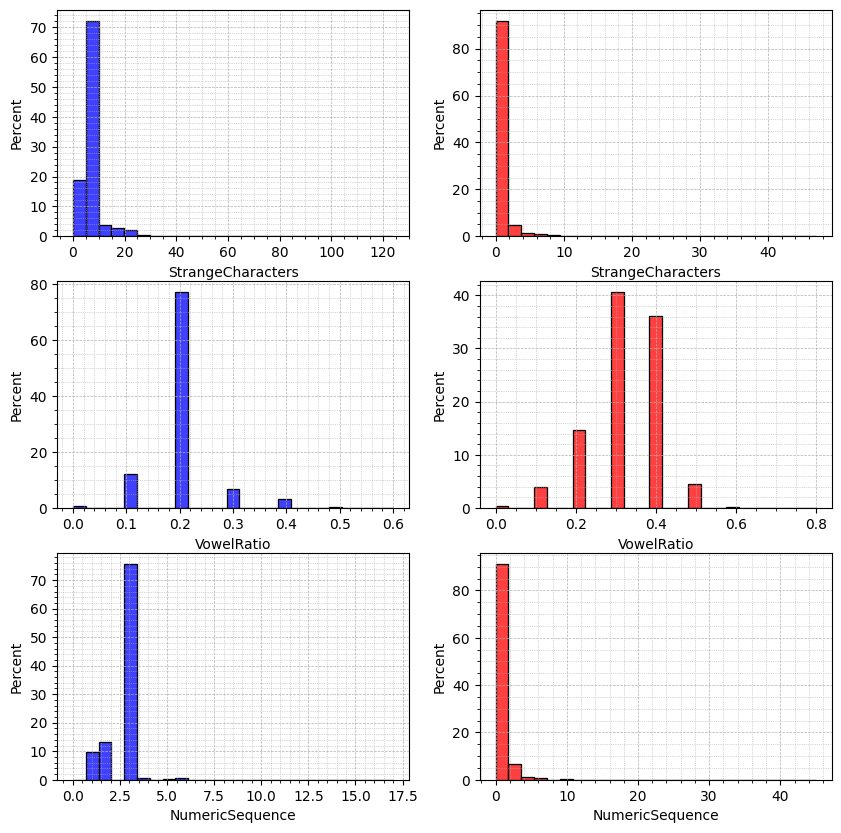

In [12]:
plt.figure(figsize=(10, 10))

i = 1
for feature in final_features[1:]:
  for j in range(2):
    plt.subplot(3, 2, i)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.minorticks_on()
    plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

    if i % 2 == 1:
      plot = sns.histplot(data=dataset_ben, x=feature, multiple='dodge', bins=25, stat='percent', color='blue')
    else:
      plot = sns.histplot(data=dataset_mal, x=feature, multiple='dodge', bins=25, stat='percent', color='red')
    i += 1


plt.show()

Sort of probability distribution for each feature. They are NO gaussian ones so it's not possible to suppose that data has Gaussian distribution

# K-NN

In [13]:
y = traffic_df['Class']

# k values to try
k_values = [5, 10, 20, 50, 100, 200, 300]

## Test for chosen features

K-NN with all the 4 features

In [14]:
def evaluate_model(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  TP = cm[1, 1]  # True Positives
  TN = cm[0, 0]  # True Negatives
  FP = cm[0, 1]  # False Positives
  FN = cm[1, 0]  # False Negatives

  # True Positive Rate
  TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
  # False Negative Rate
  FNR = FN / (TP + FN) if (TP + FN) > 0 else 0

  # Precision
  P = TP/(TP+FP) if (TP+FP) > 0 else 0

  print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
  print(f'True Positive Rate: {TPR:.2f}')
  print(f'False Negative Rate: {FNR:.2f}')
  print(f'Precision: {P:.2f}')
  print('Classification Report:')
  print(classification_report(y_test, y_pred))




Accuracy: 0.96
True Positive Rate: 0.97
False Negative Rate: 0.03
Precision: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     13378
           1       0.94      0.97      0.96     13622

    accuracy                           0.96     27000
   macro avg       0.96      0.96      0.96     27000
weighted avg       0.96      0.96      0.96     27000

k=5, Accuracy: 0.96
k=10, Accuracy: 0.95
k=20, Accuracy: 0.96
k=50, Accuracy: 0.96
k=100, Accuracy: 0.95
k=200, Accuracy: 0.95
k=300, Accuracy: 0.95


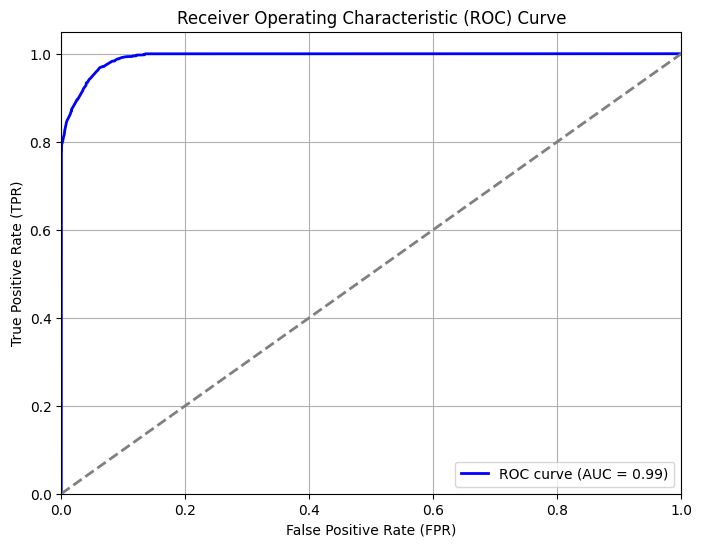

In [15]:
X = traffic_df[final_features] # 4 features

# Splitting dataset into 70% training e 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Model training
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Model evaluation
y_pred = knn.predict(X_test)
evaluate_model(y_test, y_pred)


# Accuracy tests based on different values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    print(f'k={k}, Accuracy: {accuracy_score(y_test, y_pred):.2f}')

# --- ROC curve and AUC computation ---
# Probability estimates on positive class
y_prob = knn.predict_proba(X_test)[:, 1]

# compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# show ROC curve and AUC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


KNN evaluation based on a dataset with a single feature at a time


Studying feature: TXTDnsResponse
Accuracy: 0.77
True Positive Rate: 0.78
False Negative Rate: 0.22
Precision: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77     13378
           1       0.77      0.78      0.77     13622

    accuracy                           0.77     27000
   macro avg       0.77      0.77      0.77     27000
weighted avg       0.77      0.77      0.77     27000


Studying feature: StrangeCharacters
Accuracy: 0.82
True Positive Rate: 0.84
False Negative Rate: 0.16
Precision: 0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82     13378
           1       0.82      0.84      0.83     13622

    accuracy                           0.82     27000
   macro avg       0.82      0.82      0.82     27000
weighted avg       0.82      0.82      0.82     27000


Studying feature: VowelRatio
Accuracy: 0.85
True Positive Rate: 

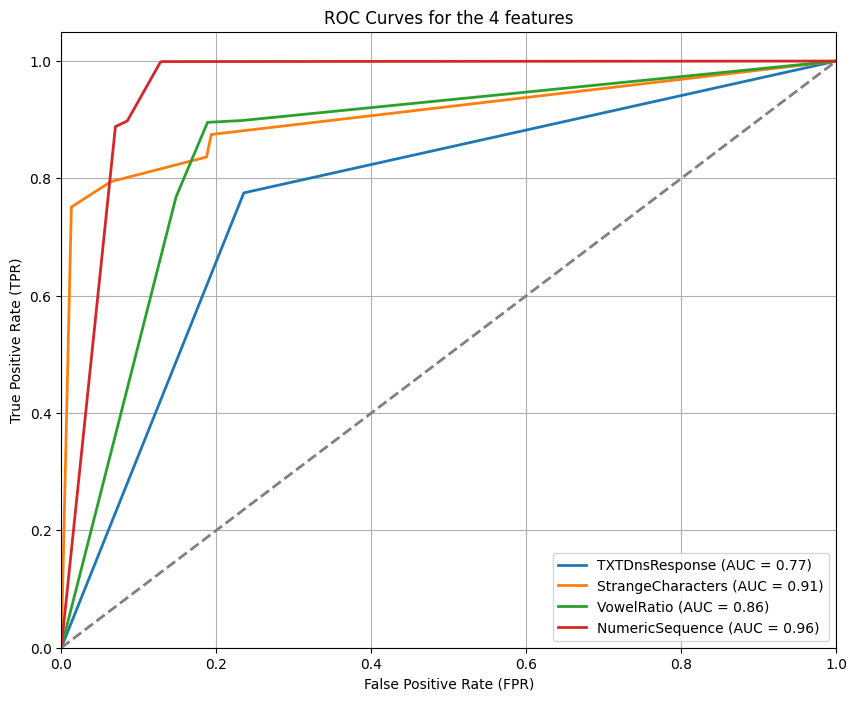

In [16]:
plt.figure(figsize=(10, 8))

for feature in X:
    print(f"\nStudying feature: {feature}")

    feature_vector = traffic_df[feature].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(feature_vector, y, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    k = 5
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Model evaluation
    y_pred = knn.predict(X_test)
    evaluate_model(y_test, y_pred)

    # Probability estimates on positive class
    y_prob = knn.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Show ROC curve for each feature
    plt.plot(fpr, tpr, lw=2, label=f'{feature} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves for the 4 features')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Test for excluded features


Studying feature: Ip
Accuracy: 0.89
True Positive Rate: 0.82
False Negative Rate: 0.18
Precision: 0.95
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     13378
           1       0.95      0.82      0.88     13622

    accuracy                           0.89     27000
   macro avg       0.89      0.89      0.89     27000
weighted avg       0.89      0.89      0.89     27000


Studying feature: ASN
Accuracy: 0.87
True Positive Rate: 0.81
False Negative Rate: 0.19
Precision: 0.92
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     13378
           1       0.92      0.81      0.87     13622

    accuracy                           0.87     27000
   macro avg       0.88      0.87      0.87     27000
weighted avg       0.88      0.87      0.87     27000



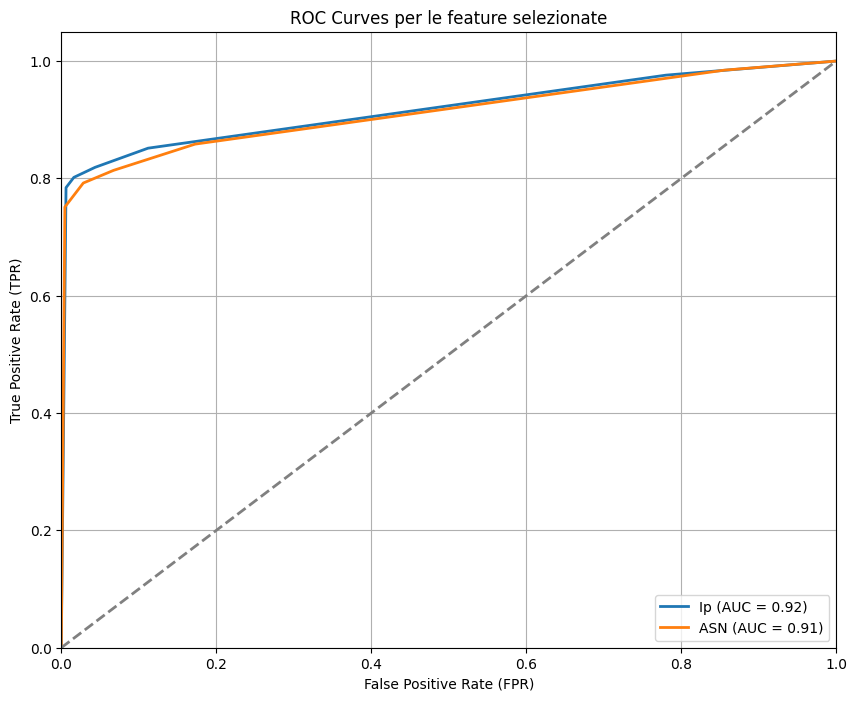

In [17]:
X = traffic_df[excluded_features]
plt.figure(figsize=(10, 8))

for feature in X:
    print(f"\nStudying feature: {feature}")

    feature_vector = traffic_df[feature].values.reshape(-1, 1)

    # Splitting dataset into training and test
    X_train, X_test, y_train, y_test = train_test_split(feature_vector, y, test_size=0.3, random_state=42)

    # Feature standardization
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Training the model
    k = 5
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Evaluating the model
    y_pred = knn.predict(X_test)
    evaluate_model(y_test, y_pred)

    # Probability estimates on positive class
    y_prob = knn.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    # show the ROC curve for the current feature
    # Traccia la curva ROC per la feature corrente, sovrapponendola alle altre
    plt.plot(fpr, tpr, lw=2, label=f'{feature} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves per le feature selezionate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


#Results of the first 25 rows of the dataset

In [24]:
X_results = traffic_df[final_features].iloc[:25].copy()
X_results['Classe_Predetta'] = y_pred[:25]
X_results['Classe_Reale'] = y_test[:25].values

header = f"{final_features[0]:^15} {final_features[1]:^15} {final_features[2]:^15} {final_features[3]:^15} {'Classe Predetta':^15} {'Classe Reale':^15}"
print(header)
print("-" * len(header))

for idx, row in X_results.iterrows():
    print(f"{row[final_features[0]]:^15} {row[final_features[1]]:^15} {row[final_features[2]]:^15.2f} {row[final_features[3]]:^15} {str(row['Classe_Predetta']):^15} {str(row['Classe_Reale']):^15}")

TXTDnsResponse  StrangeCharacters   VowelRatio    NumericSequence Classe Predetta  Classe Reale  
-------------------------------------------------------------------------------------------------
       0              11             0.20              1               0               0       
       0              11             0.20              2               0               1       
       0              24             0.20              3               1               1       
       0              15             0.10              2               0               0       
       0              23             0.10              2               1               1       
       0              19             0.20              2               0               0       
       0               0             0.40              1               1               1       
       0               9             0.20              2               1               1       
       0               0            